In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Layer, Bidirectional
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
df = pd.read_csv('/content/drive/MyDrive/PLN_Timeseries/442100110323_hourly_meteostat_features.csv')
df['READ_DATE'] = pd.to_datetime(df['READ_DATE'])
df.drop('READ_DATE_day', axis=1, inplace=True)
df.set_index('READ_DATE', inplace=True)
df

,KWH_EXP,temp,dwpt,rhum,wdir,wspd,pres,coco,lag_1,lag_6,...,season_cos,dayofweek_sin,dayofweek_cos,weekofyear_sin,weekofyear_cos,dayofyear_sin,dayofyear_cos,trend,seasonal,residual
READ_DATE,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,2.402650,26.1,25.2,95.0,140.0,5.4,1010.0,7.0,0.000000,0.000000,...,1.0,0.866025,0.5,0.120537,0.992709,0.017166,0.999853,7.932104,-0.209330,0.000425
2019-01-01 01:00:00,2.408348,27.7,24.7,84.0,321.0,5.5,1009.8,7.0,2.402650,0.000000,...,1.0,0.866025,0.5,0.120537,0.992709,0.017166,0.999853,7.932104,-0.090785,0.000425
2019-01-01 02:00:00,2.406840,28.7,24.7,79.0,329.0,7.4,1009.7,7.0,2.408348,0.000000,...,1.0,0.866025,0.5,0.120537,0.992709,0.017166,0.999853,7.932104,0.082446,0.000425
2019-01-01 03:00:00,2.256511,25.4,24.9,97.0,323.0,0.0,1010.1,7.0,2.406840,0.000000,...,1.0,0.866025,0.5,0.120537,0.992709,0.017166,0.999853,7.932104,0.077927,0.000425
2019-01-01 04:00:00,2.065598,29.5,25.0,77.0,327.0,11.1,1008.9,8.0,2.256511,0.000000,...,1.0,0.866025,0.5,0.120537,0.992709,0.017166,0.999853,7.932104,0.115159,0.000425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31 19:00:00,65.205495,28.2,23.1,74.0,150.0,9.4,1011.6,2.0,65.268262,73.044454,...,-1.0,-0.866025,-0.5,0.464723,-0.885456,0.507415,-0.861702,7.932104,-0.086264,0.000425
2024-05-31 20:00:00,65.520523,28.2,23.1,74.0,150.0,9.4,1011.6,2.0,65.205495,71.052517,...,-1.0,-0.866025,-0.5,0.464723,-0.885456,0.507415,-0.861702,7.932104,0.074562,0.000425
2024-05-31 21:00:00,66.389436,28.2,23.1,74.0,150.0,9.4,1011.6,2.0,65.520523,68.469683,...,-1.0,-0.866025,-0.5,0.464723,-0.885456,0.507415,-0.861702,7.932104,0.096503,0.000425


In [9]:
# split data train dan test. 3 tahun pertama untuk train, 2 tahun terakhir untuk test
train = df.loc['2019-01-01':'2022-12-31']
test = df.loc['2023-01-01':]

In [10]:
scaler = StandardScaler()

In [11]:
# scaling data train
train_scaled = scaler.fit_transform(train)
train_scaled = pd.DataFrame(train_scaled, columns=train.columns, index=train.index)
train_scaled



,KWH_EXP,temp,dwpt,rhum,wdir,wspd,pres,coco,lag_1,lag_6,...,season_cos,dayofweek_sin,dayofweek_cos,weekofyear_sin,weekofyear_cos,dayofyear_sin,dayofyear_cos,trend,seasonal,residual
READ_DATE,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,-0.921600,-0.466364,1.185728,1.343937,-0.420074,-0.741796,0.370252,0.708480,-1.209863,-1.209763,...,1.189486,1.321971,0.482817,0.170046,1.396816,0.024252,1.418372,-0.279837,-1.814674,0.000119
2019-01-01 01:00:00,-0.920917,0.074062,0.935136,0.514419,1.720327,-0.720198,0.268182,0.708480,-0.921581,-1.209763,...,1.189486,1.321971,0.482817,0.170046,1.396816,0.024252,1.418372,-0.279837,-0.787017,0.000119
2019-01-01 02:00:00,-0.921098,0.411829,0.935136,0.137365,1.814930,-0.309831,0.217147,0.708480,-0.920897,-1.209763,...,1.189486,1.321971,0.482817,0.170046,1.396816,0.024252,1.418372,-0.279837,0.714711,0.000119
2019-01-01 03:00:00,-0.939135,-0.702801,1.035373,1.494759,1.743978,-1.908102,0.421287,0.708480,-0.921078,-1.209763,...,1.189486,1.321971,0.482817,0.170046,1.396816,0.024252,1.418372,-0.279837,0.675535,0.000119
2019-01-01 04:00:00,-0.962042,0.682042,1.085491,-0.013457,1.791279,0.489305,-0.191132,0.927251,-0.939116,-1.209763,...,1.189486,1.321971,0.482817,0.170046,1.396816,0.024252,1.418372,-0.279837,0.998292,0.000119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,-0.891599,-0.702801,0.584308,1.117705,1.377390,0.899672,-0.956655,1.146022,-1.003674,-1.077062,...,1.189486,-1.321971,0.482817,-0.000701,1.407110,-0.024252,1.418372,-1.071708,-0.826064,0.262614
2022-12-31 20:00:00,-0.870325,-0.669024,0.534190,1.042294,1.436517,0.899672,-1.007690,1.146022,-0.891580,-1.074522,...,1.189486,-1.321971,0.482817,-0.000701,1.407110,-0.024252,1.418372,-1.079512,0.664686,0.281460
2022-12-31 21:00:00,-0.870764,-0.229928,0.634426,0.589829,1.590247,2.519541,-0.650446,0.927251,-0.870306,-1.072373,...,1.189486,-1.321971,0.482817,-0.000701,1.407110,-0.024252,1.418372,-1.083304,1.300663,0.267678


In [12]:
# scaling data test
test_scaled = scaler.transform(test)
test_scaled = pd.DataFrame(test_scaled, columns=test.columns, index=test.index)
test_scaled

,KWH_EXP,temp,dwpt,rhum,wdir,wspd,pres,coco,lag_1,lag_6,...,season_cos,dayofweek_sin,dayofweek_cos,weekofyear_sin,weekofyear_cos,dayofyear_sin,dayofyear_cos,trend,seasonal,residual
READ_DATE,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,-0.857399,-0.061044,0.885018,0.589829,1.590247,3.297079,0.166112,0.708480,-0.865887,-1.003584,...,1.189486,-4.116180e-16,1.156547,-0.000701,1.407110,0.024252,1.418372,-1.083923,-1.232319,0.385328
2023-01-01 01:00:00,-0.865644,0.006509,0.885018,0.514419,1.519295,1.288441,-0.191132,0.708480,-0.857381,-0.891495,...,1.189486,-4.116180e-16,1.156547,-0.000701,1.407110,0.024252,1.418372,-1.084548,-0.672264,0.348304
2023-01-01 02:00:00,-0.872474,0.276722,0.935136,0.288186,1.578422,1.698808,-0.242167,0.708480,-0.865625,-0.870222,...,1.189486,-4.116180e-16,1.156547,-0.000701,1.407110,0.024252,1.418372,-1.085061,0.890885,0.281089
2023-01-01 03:00:00,-0.869078,0.513159,1.085491,0.137365,1.708501,3.297079,-0.191132,0.708480,-0.872455,-0.870662,...,1.189486,-4.116180e-16,1.156547,-0.000701,1.407110,0.024252,1.418372,-1.084353,0.758190,0.292081
2023-01-01 04:00:00,-0.871847,0.546936,1.035373,0.061954,1.637549,2.497943,-0.497341,0.708480,-0.869059,-0.876746,...,1.189486,-4.116180e-16,1.156547,-0.000701,1.407110,0.024252,1.418372,-1.080306,0.561284,0.283001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31 19:00:00,6.613860,0.242946,0.133243,-0.239689,-0.301820,0.122135,1.186810,-0.385377,6.621333,7.554053,...,-0.840700,-1.321971e+00,-0.864643,0.657605,-1.254965,0.716858,-1.216982,-0.279837,-0.747824,0.000119
2024-05-31 20:00:00,6.651659,0.242946,0.133243,-0.239689,-0.301820,0.122135,1.186810,-0.385377,6.613802,7.315062,...,-0.840700,-1.321971e+00,-0.864643,0.657605,-1.254965,0.716858,-1.216982,-0.279837,0.646364,0.000119
2024-05-31 21:00:00,6.755916,0.242946,0.133243,-0.239689,-0.301820,0.122135,1.186810,-0.385377,6.651601,7.005176,...,-0.840700,-1.321971e+00,-0.864643,0.657605,-1.254965,0.716858,-1.216982,-0.279837,0.836572,0.000119


In [13]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [15]:
# jika datanya diambil setiap 1 jam maka timestep nya 24

time_steps = 24
# reshape ke bentuk 3D array
X_train, y_train = create_dataset(train_scaled, train_scaled['KWH_EXP'], time_steps)
X_test, y_test = create_dataset(test_scaled, test_scaled['KWH_EXP'], time_steps)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(35040, 24, 59) (35040,)
(12384, 24, 59) (12384,)


In [16]:
model = Sequential()
model.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Bidirectional(LSTM(units=64, return_sequences=False)))
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 24, 256)             │         192,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 356,993 (1.36 MB)

 Trainable params: 356,993 (1.36 MB)

 Non-trainable params: 0 (0.00 B)


SPLITTING DATA RATIO :

* Train data : tahun 2019-2022 akhir
* Test data : tahun 2023-ujung data
* Validation data : diambil 10% dari training data

In [18]:
#  callback
# early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')
# learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

# training
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.5287 - val_loss: 0.3116 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.6683 - val_loss: 0.2695 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1708 - val_loss: 0.2706 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2000 - val_loss: 0.1272 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2328 - val_loss: 0.0517 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1857 - val_loss: 0.0406 - learning_rate: 9.0484e-04
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1145 - val_loss: 0.0382 - learning_rate: 8.1873e-04
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0894 - val_loss: 0.0353 - learning_rate: 7.4082e-04
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0711 - val_loss: 0.0338 - learning_rate: 6.703

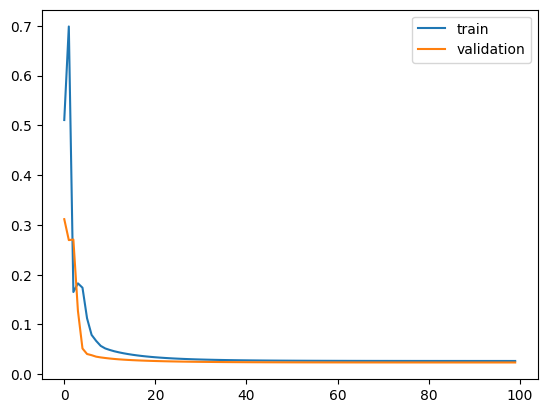

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot   (history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [20]:
# predict

y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)


387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


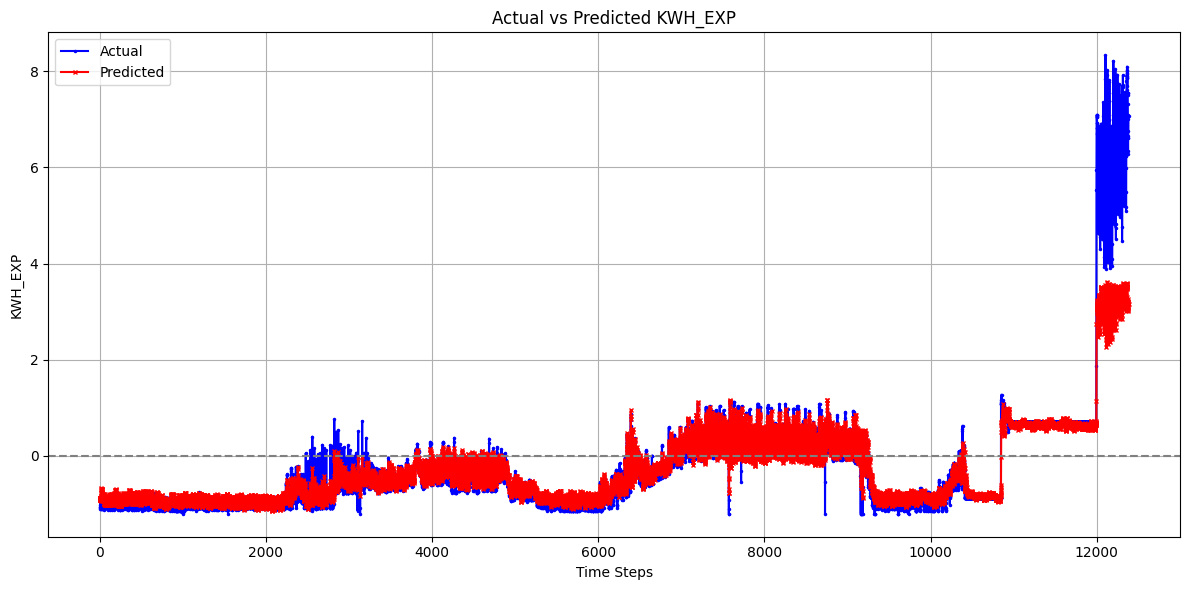

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, marker='.', label='Actual', color='blue', markersize=3)
plt.plot(y_pred, marker='x', label='Predicted', color='red', markersize=3)
plt.axhline(0, color='gray', linestyle='--')  # Garis referensi
plt.title('Actual vs Predicted KWH_EXP')
plt.xlabel('Time Steps')
plt.ylabel('KWH_EXP')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [22]:
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 0.35126561854552363
MAE: 0.19208616348180532
R2: 0.8057299422531351
MAPE: 1.155968989759054


# ATTENTION

In [23]:
# Define Attention Layer
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def call(self, inputs):
        attention_weights = tf.nn.softmax(tf.matmul(inputs, inputs, transpose_b=True), axis=-1)
        context_vector = tf.matmul(attention_weights, inputs)
        return context_vector

# Model definition with Attention
input_shape = (X_train.shape[1], X_train.shape[2])
inputs = Input(shape=input_shape)
x = LSTM(units=128, return_sequences=True)(inputs)
x = AttentionLayer()(x)
x = LSTM(units=64, return_sequences=False)(x)
outputs = Dense(units=1)(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

# Training the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 24, 59)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 24, 128)             │          96,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer (AttentionLayer)     │ (None, 24, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 145,729 (569.25 KB)

 Trainable params: 145,729 (569.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.5263 - val_loss: 0.1192 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2731 - val_loss: 0.2914 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2614 - val_loss: 0.2086 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1730 - val_loss: 0.0588 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1715 - val_loss: 0.0679 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1205 - val_loss: 0.0549 - learning_rate: 9.0484e-04
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1073 - val_loss: 0.0503 - learning_rate: 8.1873e-04
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1081 - val_loss: 0.0508 - learning_rate: 7.4082e-04
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0964 - val_loss: 0.0446 - learning_rate: 6.703

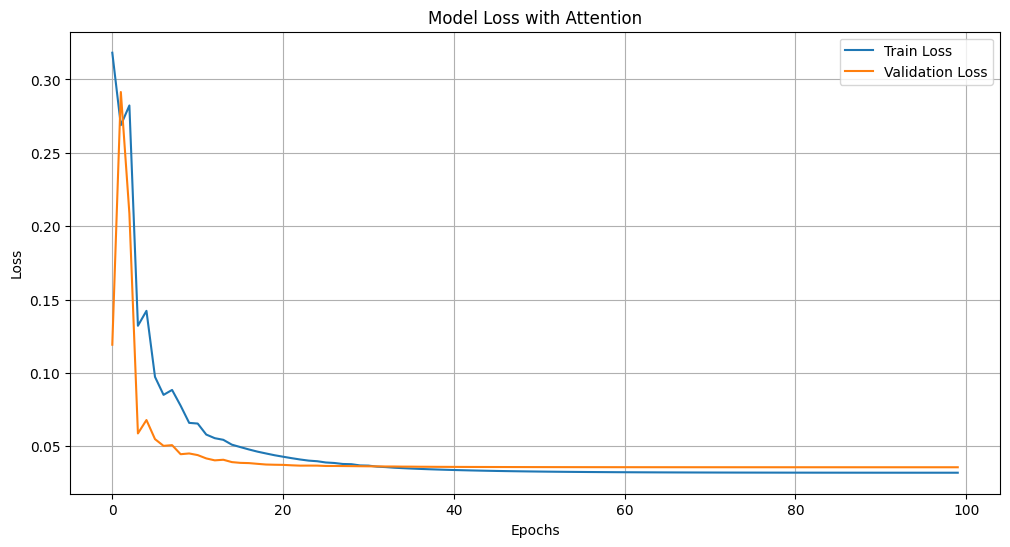

387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [24]:
# Plotting the loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Predictions
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

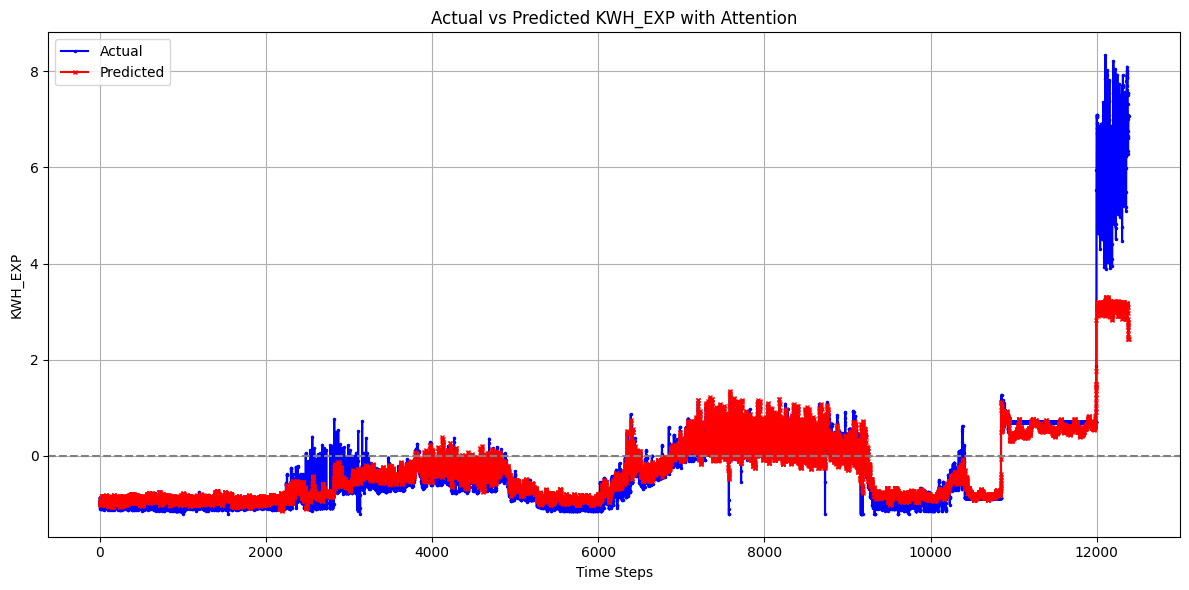

In [25]:
# Actual vs Predicted plot
plt.figure(figsize=(12, 6))
plt.plot(y_test, marker='.', label='Actual', color='blue', markersize=3)
plt.plot(y_pred, marker='x', label='Predicted', color='red', markersize=3)
plt.axhline(0, color='gray', linestyle='--')  # Reference line
plt.title('Actual vs Predicted KWH_EXP with Attention')
plt.xlabel('Time Steps')
plt.ylabel('KWH_EXP')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [26]:
# Metrics
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R²:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 0.40125010968208785
MAE: 0.2299374502513605
R²: 0.7780856484000789
MAPE: 1.2162405569718575


BILSTM ATTENTION

In [27]:
# Define Attention Layer
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def call(self, inputs):
        attention_weights = tf.nn.softmax(tf.matmul(inputs, inputs, transpose_b=True), axis=-1)
        context_vector = tf.matmul(attention_weights, inputs)
        return context_vector

# Model definition with Attention
input_shape = (X_train.shape[1], X_train.shape[2])
inputs = Input(shape=input_shape)
x = Bidirectional(LSTM(units=128, return_sequences=True))(inputs)
x = AttentionLayer()(x)
x = Bidirectional(LSTM(units=64, return_sequences=False))(x)
outputs = Dense(units=1)(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

# Training the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 24, 59)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 24, 256)             │         192,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_1 (AttentionLayer)   │ (None, 24, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 356,993 (1.36 MB)

 Trainable params: 356,993 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.6690 - val_loss: 0.4455 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.6298 - val_loss: 0.0934 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1662 - val_loss: 0.0649 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1344 - val_loss: 0.0684 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1446 - val_loss: 0.0561 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1461 - val_loss: 0.0639 - learning_rate: 9.0484e-04
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1970 - val_loss: 0.0691 - learning_rate: 8.1873e-04
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1464 - val_loss: 0.0541 - learning_rate: 7.4082e-04
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1448 - val_loss: 0.0574 - learning_rate: 6.703

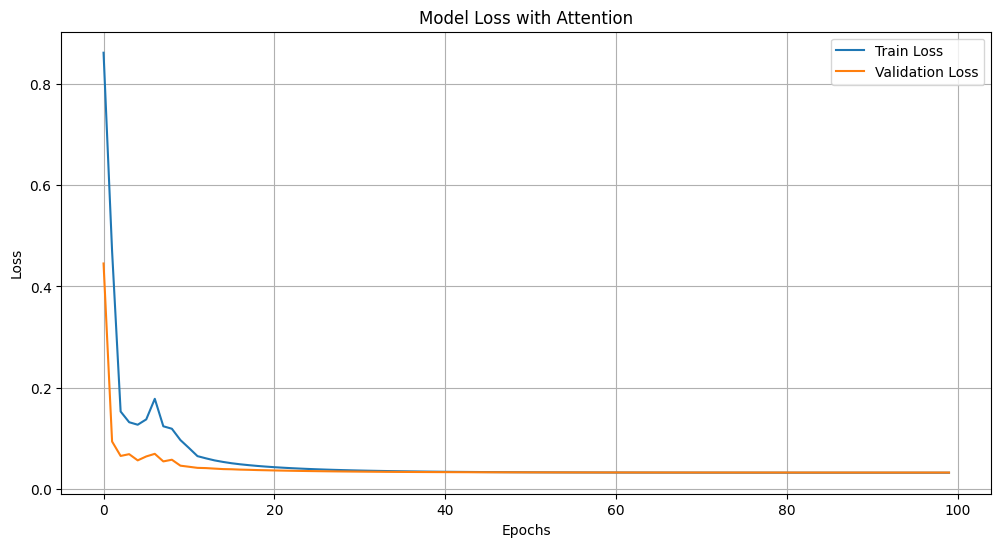

387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [28]:
# Plotting the loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Predictions
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

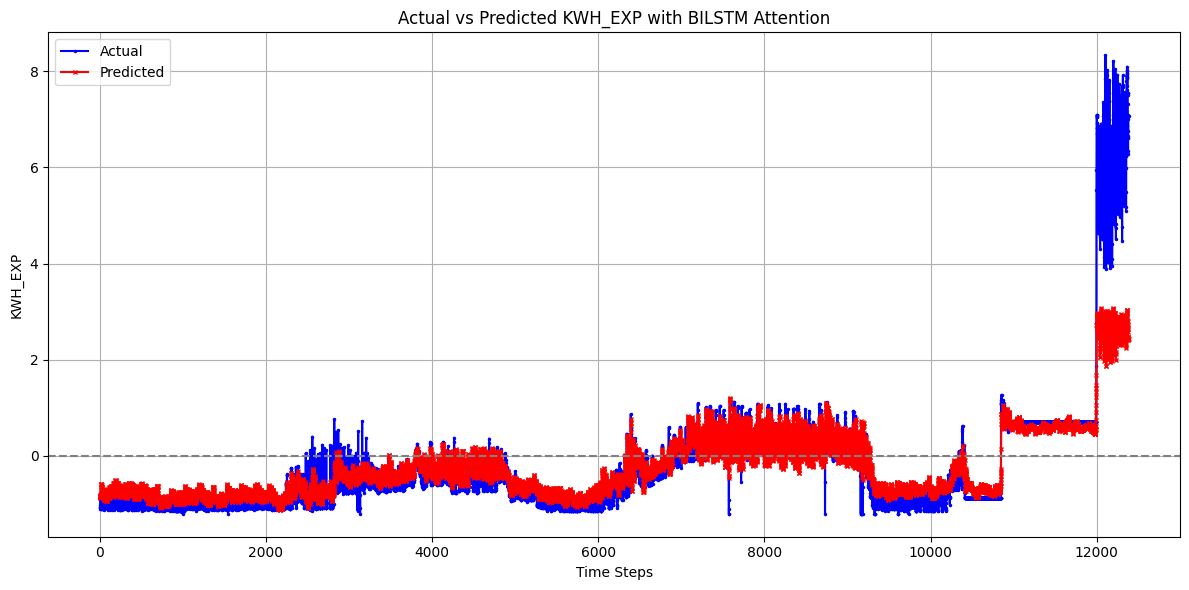

In [29]:
# Actual vs Predicted plot
plt.figure(figsize=(12, 6))
plt.plot(y_test, marker='.', label='Actual', color='blue', markersize=3)
plt.plot(y_pred, marker='x', label='Predicted', color='red', markersize=3)
plt.axhline(0, color='gray', linestyle='--')  # Reference line
plt.title('Actual vs Predicted KWH_EXP with BILSTM Attention')
plt.xlabel('Time Steps')
plt.ylabel('KWH_EXP')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [30]:
# Metrics
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R²:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 0.4988072704797018
MAE: 0.267750554364011
R²: 0.7241309364637143
MAPE: 1.682009578507269


# LSTM

In [31]:
model = Sequential()
model.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dense(units=1))

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

# Training the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 24, 59)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 24, 256)             │         192,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_1 (AttentionLayer)   │ (None, 24, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 356,993 (1.36 MB)

 Trainable params: 356,993 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0667 - val_loss: 0.3055 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1503 - val_loss: 0.1139 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1943 - val_loss: 0.0646 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1322 - val_loss: 0.0494 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1342 - val_loss: 0.0765 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1458 - val_loss: 0.0749 - learning_rate: 9.0484e-04
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1223 - val_loss: 0.0400 - learning_rate: 8.1873e-04
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1094 - val_loss: 0.0386 - learning_rate: 7.4082e-04
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1355 - val_loss: 0.0357 - learning_rate: 6.703

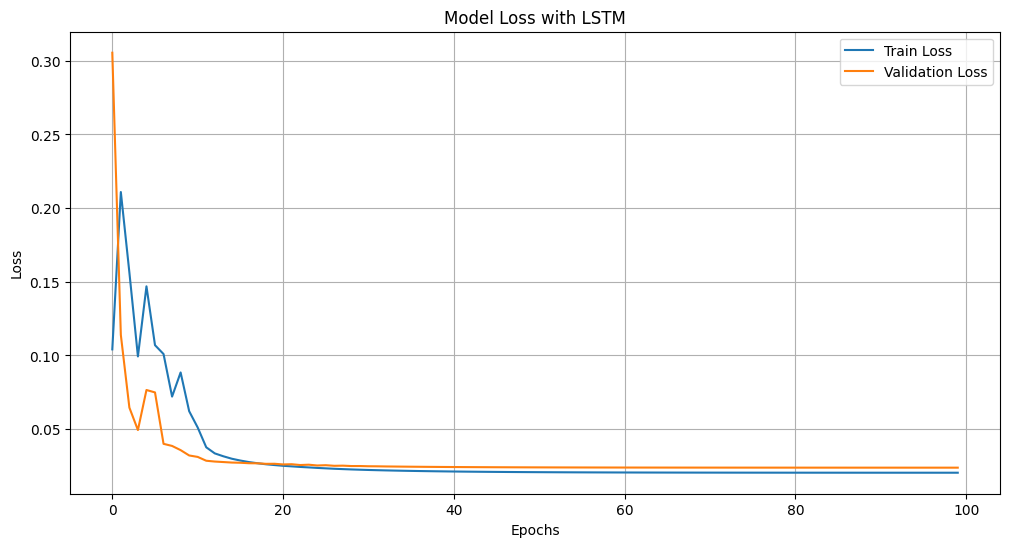

387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [32]:
# Plotting the loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Predictions
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

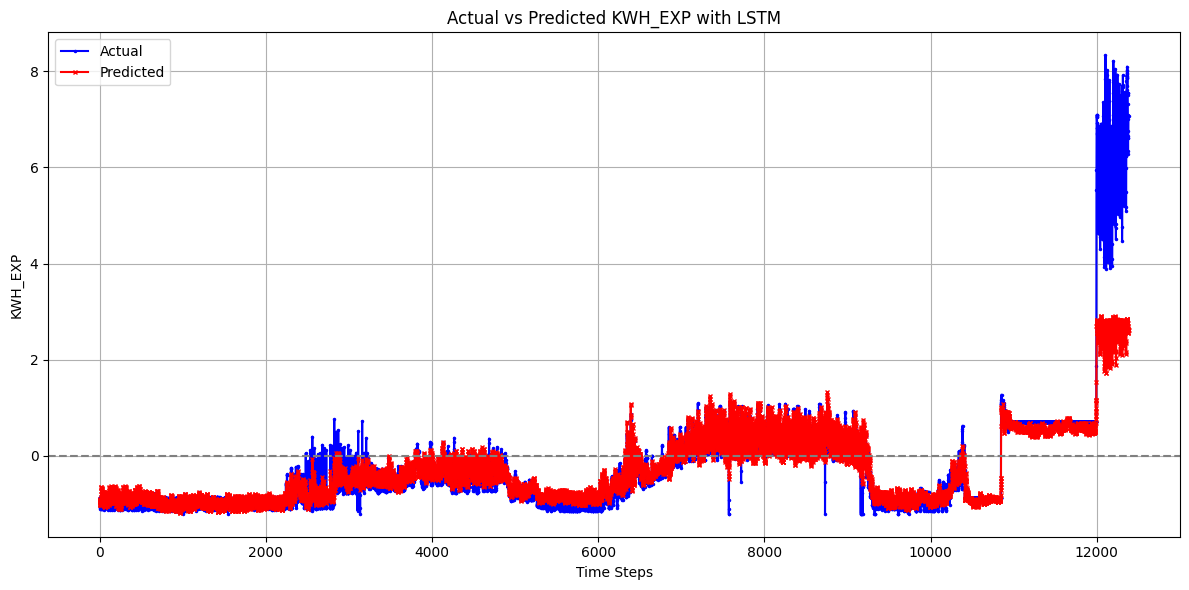

In [33]:
# Actual vs Predicted plot
plt.figure(figsize=(12, 6))
plt.plot(y_test, marker='.', label='Actual', color='blue', markersize=3)
plt.plot(y_pred, marker='x', label='Predicted', color='red', markersize=3)
plt.axhline(0, color='gray', linestyle='--')  # Reference line
plt.title('Actual vs Predicted KWH_EXP with LSTM')
plt.xlabel('Time Steps')
plt.ylabel('KWH_EXP')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [34]:
# Metrics
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R²:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 0.49124506961195125
MAE: 0.22089091557281595
R²: 0.7283132677870997
MAPE: 0.9326593491597142
